Preprocess Training Data
=====================

For the generation of training data you need aligned pairs of fluorescence microscopic (FM) and electron microscopic (EM) images. The FM images must be saved in one directory and the EM images in another directory.<br/> <br/>
At first import some python packages and connect python to ImageJ/Fiji. Therefore you have to insert the **path to your Fiji** installation and make sure, that **Fiji is closed**. If Fiji is not closed problems with Fiji could occure. 

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import imagej
ij = imagej.init('/home/s353960/rickdata/Programme/Fiji.app/') # Insert path to your Fiji app
from jnius import autoclass
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import imageio # dependencies: Numpy, Pillow
import cv2

from PIL import Image
from tifffile import imread
from tifffile import imwrite
from csbdeep.utils import plot_some
from csbdeep.utils.tf import limit_gpu_memory
from csbdeep.data import RawData, create_patches_reduced_target

Added 502 JARs to the Java classpath.


Using TensorFlow backend.


Execute the following cell to limit the GPU memory consumption to the half amount of the GPU memory. A limitation of the GPU memory is only neccessary, if there are other processes, that need also the GPU. If you are using the GPU only for the training of this network you do not need to execute the following cell. 

In [2]:
limit_gpu_memory(fraction=1/2)

In [3]:
# directory for raw fluorescence microscopic images:
GTdirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/fluo_additional/'

# directory for processed fluorescence microscopic images:
Xdirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/fluo_training2/'
#os.mkdir(Xdirectory) # uncomment if directory do not exist already

After that, the FM image will be processed. In this step the image will be converted in a greyscale image and downsized to 256x256 pixels. If a RGB image was presented, the **blue channel will be extracted** (preset). If the chromatin signal is in another channel located, you have to specify the chromatin channel in the code cell below. After execution of this cell the number of images in the directory with the raw FM images and in the directory with the processed FM images must be equal.

<div align="center">
    <br/>
  This is an example for a processed image:
  <img src="https://raw.githubusercontent.com/Rickmic/Deep_CLEM/assets/fluo_processed.png"/>
</div>

In [4]:

# convert RGB image or a z stack into a greyscale image:
def StackRGB(shape, IM):
    channel2 = shape[2]
    if channel2 <=4: # image is a RGB image
        channelofI = IM[:, :, 2] # change channel number if channel for correlation of 
        # light microscopic image differs 0 = red; 1 = green; 2 = blue
    else: # image is a stack
        channelofI = IM[0, :, :]
    # return greyscale image:
    return channelofI 

Image.MAX_IMAGE_PIXELS = None # avoid error message for extremely large images


print('groundtruth--------------------------------------------------')
for filename in os.listdir(GTdirectory): # loop over all files in the GTdirectory
    if filename.endswith((".png", ".tif", ".tiff")): # check if file is an image
        GTpath = os.path.join(GTdirectory, filename) 
        IM = imageio.imread(GTpath) # open image
        dimension = IM.ndim
        shape = IM.shape
        if dimension >= 3: # RGB image or stack
            channelofI = StackRGB(shape, IM)
        else: # greyscale image
            channelofI = IM
        GT = channelofI
        #GT = GT[:960, :] # uncomment if ground truth image should be cropped [y, x]
        GT = cv2.resize(GT, dsize=(256, 256), interpolation=cv2.INTER_LINEAR) # resize image to 256x256
        name, ext = os.path.splitext(filename) # split filename in name and extension (ext)
        writepath = os.path.join(Xdirectory, name + '.tif')
        imwrite(writepath, GT) # save image as .tif
        
        # print feedback
        print(filename + ': processed')
        text = 'shape: %s to  %s' % (shape, GT.shape)
        print(text)
        print(' ')



groundtruth--------------------------------------------------
s9_ds.png: processed
shape: (954, 1280) to  (256, 256)
 
s6_ds.png: processed
shape: (954, 1280) to  (256, 256)
 
s8_ds.png: processed
shape: (951, 1280) to  (256, 256)
 
s7_ds.png: processed
shape: (954, 1280) to  (256, 256)
 


## 2. Preprocess electron microscopic images

For this step you have to specify again two directories. One **directory with the raw EM images** and one **directory for the processed EM images** as ground truth for the training process. The directory with the raw EM images should contain exactly the same number of images as the directory for the raw FM images. The dimensions and the name of each EM image should be the same as the corresponding FM image. The directory for the processed EM images should be an empty directory to save processed images.

<div align="center">
    <br/>
  Here is an example for an unprocessed image:
  <img src="https://raw.githubusercontent.com/Rickmic/Deep_CLEM/assets/sem_unprocessed.png" width="300" /> 
    <br/>
</div>

In [5]:
# directory for raw electron microscopic images:
IPdirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/sem_additional/'

# directory for processed fluorescence microscopic images:
Ydirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/sem_training2/'
#os.mkdir(Ydirectory) # comment out, if directory exists already

In this step the EM image will be processed. Therefore the histogramm will be equalized. The image will be converted in a greyscale image and downsized to 256x256 pixels. If a RGB image was presented, the red channel will be extracted (preset). If the chromatin signal is in another channel located, you have to specify this channel in the code cell below. After execution of this cell the number of images in the directory with the raw EM images and in the directory with the processed images must be equal.

<div align="center">
    <br/>
    This is an example for a processed image with histogram equalization:
  <img src="https://raw.githubusercontent.com/Rickmic/Deep_CLEM/assets/sem_processed.png"/>
</div>


In [6]:
# convert RGB image or a z stack into a greyscale image:
def StackRGB(shape, IM):
    channel2 = shape[2]
    if channel2 <=4: # image is a RGB image
        channelofI = IM[:, :, 2] # change channel number if channel for correlation of
        # electron microscopic image differs 0 = red; 1 = green; 2 = blue
    else: # image is a stack
        channelofI = IM [0, :, :]
    # return greyscale image:
    return channelofI

Image.MAX_IMAGE_PIXELS = None # avoid error message for extremely large images


print('input--------------------------------------------------------')
for filename in os.listdir(IPdirectory): # loop over all files in the GTdirectory
    if filename.endswith((".png", ".tif", ".tiff")): # check if file is an image
        print(filename)
        IPpath = os.path.join(IPdirectory, filename) 
        
        # equalize histogram with a imageJ macro:
        WindowManager = autoclass('ij.WindowManager')
        macro = """
        #@ String name
        open(name);
        run("Enhance Contrast...", "saturated=0.3 equalize");
        """
        args = {
        'name': IPpath
        }
        ij.py.run_macro(macro, args)
        IM = WindowManager.getCurrentImage()
        # ImagePlus object to numpy array
        IM = ij.py.from_java(IM)
        IM = IM.astype(np.uint8)
        
        dimension = IM.ndim
        shape = IM.shape
        if dimension >= 3: # RGB image or stack
            channelofI = StackRGB(shape, IM)
        else: # greyscale image
            channelofI = IM
        #channelofI = channelofI[:960, :] # uncomment if input image should be cropped [y, x]
        channelofI = cv2.resize(channelofI, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
        IP = np.stack((channelofI, channelofI), axis = 0) # generate Z-stack for training process
        name, ext = os.path.splitext(filename) # split filename in name and extension (ext)
        writepath = os.path.join(Ydirectory, name + '.tif')
        imwrite(writepath, IP) # save image as .tif
        
        # print feedback:
        print(filename + ': processed')
        text = 'shape: %s to  %s' % (shape, IP.shape)
        print(text)
        print(' ')

input--------------------------------------------------------
s8_ds.png
s8_ds.png: processed
shape: (951, 1280) to  (2, 256, 256)
 
s7_ds.png
s7_ds.png: processed
shape: (954, 1280) to  (2, 256, 256)
 
s9_ds.png
s9_ds.png: processed
shape: (954, 1280) to  (2, 256, 256)
 
s6_ds.png
s6_ds.png: processed
shape: (954, 1280) to  (2, 256, 256)
 


## 3. Generate training dataset

This part of the script is based on [a jupyter notebook](https://nbviewer.jupyter.org/url/csbdeep.bioimagecomputing.com/examples/denoising3D/1_datagen.ipynb).
At first you need to specify two directories. One directory should contain all preprocessed EM images. This directory was normally created during the preprocessing step and contains only images with the dimension 2x256x256. Another directory should contain all preprocessed FM images. This images should have the dimensions 256x256. In this step it is very important, that the corresponding **EM and FM images** are named with **exactly the same name**. <br/> Furthermore you have to insert the path and filename where the processed training data should be saved. The filename should end with .npz.

In [10]:
# Path to a folder with preprocessed electron microscopic images:
Ydirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/sem_training2/'
# Path to a folder with preprocessed electron microscopic images:
Xdirectory = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/fluo_training2/'
# Path for the training data:
train_npz = '/home/s353960/rickdata/F1 Praktikum/04_2validation_images/my_training_data2.npz'

In [11]:
#create basepath, source_dirs and target_dir

commonpath = os.path.commonpath([Ydirectory, Xdirectory])

def getdirectory(directory):
    if os.path.basename(directory) is '':
        path = os.path.dirname(directory)
        folder = os.path.basename(path)
    else:
        folder = os.path.basename(directory)
    return(folder)

directory = Ydirectory
Yfolder = getdirectory(directory)

directory = Xdirectory
Xfolder = getdirectory(directory)

In [12]:
raw_data = RawData.from_folder (
    basepath    = commonpath,
    source_dirs = [Yfolder],
    target_dir  = Xfolder,
    axes        = 'ZYX',
)

In [13]:
X, Y, XY_axes = create_patches_reduced_target (
    raw_data            = raw_data,
    patch_size          = (None,128,128),
    n_patches_per_image = 16,
    target_axes         = 'YX',
    reduction_axes      = 'Z',
    save_file           = train_npz,
)

    4 raw images x    1 transformations   =     4 images
    4 images     x   16 patches per image =    64 patches in total
Input data:
/home/s353960/rickdata/F1 Praktikum/04_2validation_images: target='fluo_training2', sources=['sem_training2'], axes='ZYX', pattern='*.tif*'
Transformations:
1 x Broadcast target image to the shape of source
Patch size:
2 x 128 x 128


100%|██████████| 4/4 [00:00<00:00, 30.64it/s]

Saving data to /home/s353960/rickdata/F1 Praktikum/04_2validation_images/my_training_data2.npz.


Now you are ready with preprocessing. If you wish, you can display with the next cells the dimensions of the training data and some generated training data pairs.

In [14]:
print("shape of X   =", X.shape)
print("shape of Y   =", Y.shape)
print("axes  of X,Y =", XY_axes)

shape of X   = (64, 1, 2, 128, 128)
shape of Y   = (64, 1, 1, 128, 128)
axes  of X,Y = SCZYX


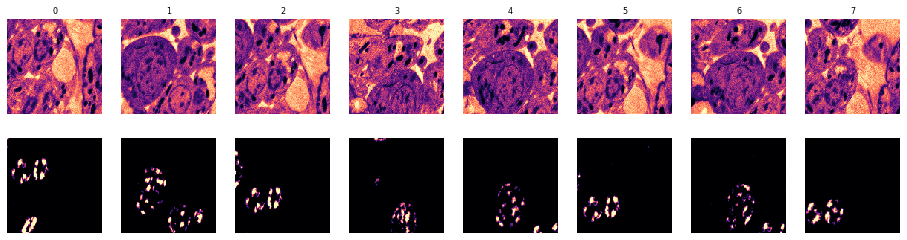

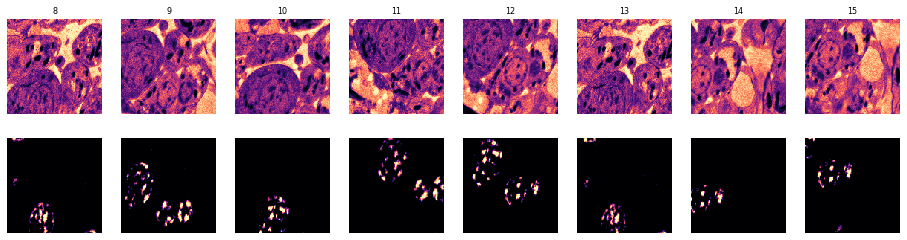

In [15]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;